In [32]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [35]:
images_path = "/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/Images"
train_csv_path = '/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/train.xlsx'
test_csv_path = '/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/test.xlsx'

In [36]:
train_df = pd.read_excel(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [37]:
print(len(train_df))
print(len(test_df))

5247
584


In [38]:
trdata = {
    'image': [],
    'label': []
}
combinedf = pd.DataFrame(trdata)

tedata = {
    'image': [],
    'label': []
}
testdf = pd.DataFrame(tedata)

label_map = {
    "non_damage": 0,
    "damaged_infrastructure": 1,
    "damaged_nature": 2,
    "fires": 3,
    "flood": 4,
    "human_damage": 5
}

combinedf['label'] = train_df['label'].map(label_map)
testdf['label'] = test_df['label'].map(label_map)

def replace_string(row):
  return row.replace('.JPG', '.jpg')
combinedf['image'] = train_df['image'].apply(replace_string)
testdf['image'] = test_df['image'].apply(replace_string)


In [39]:
#combinedf = shuffle(combinedf, random_state=42)
traindf=combinedf[:4663]
validdf= combinedf[4663:]

In [40]:
print(len(combinedf))
print(len(traindf))
print(len(validdf))
print(len(testdf))

5247
4663
584
584


In [41]:
# traindf['image_exist'] = traindf['image'].apply(lambda x: os.path.exists(os.path.join(images_path, x)))

In [42]:
# traindf = traindf[traindf['image_exist']]
# traindf = traindf.drop(columns=['image_exist'])

In [43]:
traindf

,image,label
0,buildingfire_2017-02-05_04-06-10.jpg,1
1,isiscrimes_2015-08-04_00-18-33.jpg,5
2,earthquake_2017-11-13_07-23-10.jpg,1
3,ad_2017-11-25_07-56-53.jpg,0
4,hurricanesandy_2017-10-29_22-36-42.jpg,4
...,...,...
4658,ad_2017-11-25_09-56-23.jpg,0
4659,hurricaneirma_2017-11-21_19-52-42.jpg,2
4660,yemencrisis_2016-02-13_02-40-54.jpg,5
4661,building_2017-10-30_17-03-48.jpg,0


In [44]:
validdf

,image,label
4663,treesfalling_2013-12-22_18-58-11.jpg,2
4664,ad_2017-11-25_04-12-10.jpg,0
4665,ad_2017-11-25_10-45-52.jpg,0
4666,naturaldisaster_2017-10-13_07-10-42.jpg,2
4667,wreckedcar_2017-02-12_16-59-16.jpg,1
...,...,...
5242,cars_2017-10-30_17-48-22.jpg,0
5243,buildingfire_2016-12-07_17-48-56.jpg,3
5244,nature_2017-10-30_17-47-15.jpg,0
5245,ad_2017-11-25_11-07-37.jpg,0


In [45]:
testdf

,image,label
0,ad_2017-11-25_10-36-26.jpg,0
1,building_2017-10-30_17-26-34.jpg,0
2,floodwater_2017-09-04_04-46-10.jpg,4
3,accrafloods_2015-06-06_16-59-56.jpg,4
4,buildingfire_2016-10-02_03-07-17.jpg,3
...,...,...
579,floodwater_2017-08-27_23-49-50.jpg,4
580,nature_2017-10-30_17-47-50.jpg,0
581,earthquake_2017-11-13_23-23-28.jpg,1
582,ad_2017-11-25_08-21-38.jpg,0


In [46]:
class_counts = traindf['label'].value_counts()
print(class_counts)

0    2367
1    1114
2     405
4     300
3     274
5     203
Name: label, dtype: int64


In [47]:
class_counts = validdf['label'].value_counts()
print(class_counts)

0    299
1    132
2     54
4     48
3     35
5     16
Name: label, dtype: int64


In [48]:
class_counts = testdf['label'].value_counts()
print(class_counts)

0    291
1    144
2     55
3     37
4     36
5     21
Name: label, dtype: int64


In [49]:
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_test = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [50]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_path, self.dataframe.iloc[index]['image'])
        image = Image.open(img_name)
        label = self.dataframe.iloc[index]['label']

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [51]:
train_dataset = CustomDataset(traindf, images_path, transform=transform_train)
validation_dataset = CustomDataset(validdf, images_path, transform=transform_test)
test_dataset = CustomDataset(testdf, images_path, transform=transform_test)

In [52]:
class_counts = traindf['label'].value_counts()
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(len(class_counts))])
class_weights = class_weights / class_weights.sum()

In [53]:
class_weights = class_weights.to(device,dtype=torch.float32)

In [54]:
class CustomDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomDenseNet, self).__init__()
        densenet = models.densenet201(pretrained=True)
        for param in densenet.parameters():
            param.requires_grad = False
        self.densenet = nn.Sequential(*list(densenet.children())[:-1])
        self.fc = nn.Linear(densenet.classifier.in_features, num_classes)
        
    def forward(self, x):
        x = self.densenet(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [55]:
model = CustomDenseNet(num_classes=6)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader= DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [57]:
print(len(train_loader))
print(len(test_loader))
print(len(valid_loader))

37
5
5


In [58]:
# for inputs, labels in train_loader:
#     print(inputs.shape, labels.shape)

In [59]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# for idx, (images, labels) in enumerate(train_loader):
#     try:
#         if images.shape[1] == 1:
#             print('Image batch dimensions:', idx, images.shape)
#             print('Image label dimensions:', idx, labels.shape)
#     except Exception as e:
#         print(f"Error occurred while processing batch {idx}: {e}")

# print("No")

In [60]:
model.to(device)

CustomDenseNet(
  (densenet): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=

In [61]:
learning_rate = 0.0001
momentum = 0.9
beta_2 = 0.999
epsilon = 1e-8
weight_decay = 0.0
amsgrad = False

In [62]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

num_iters=10000
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

patience = 8
best_val_loss = float('inf')
counter = 0

In [63]:
iter= 0
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        iter+=1

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()


    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_samples
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct_predictions / total_samples
    test_loss_history.append(epoch_loss)
    test_acc_history.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Best Model Save")
        model.train()
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}.')
            break

Epoch [1/274], Train Loss: 1.5488, Accuracy: 0.3847
Epoch [1/274], Validation Loss: 1.3689, Accuracy: 0.4863
Best Model Save
Epoch [2/274], Train Loss: 1.2493, Accuracy: 0.5561
Epoch [2/274], Validation Loss: 1.1913, Accuracy: 0.5753
Best Model Save
Epoch [3/274], Train Loss: 1.1296, Accuracy: 0.6116
Epoch [3/274], Validation Loss: 1.1052, Accuracy: 0.6233
Best Model Save
Epoch [4/274], Train Loss: 1.0430, Accuracy: 0.6386
Epoch [4/274], Validation Loss: 1.0366, Accuracy: 0.6421
Best Model Save
Epoch [5/274], Train Loss: 0.9843, Accuracy: 0.6592
Epoch [5/274], Validation Loss: 0.9785, Accuracy: 0.6644
Best Model Save
Epoch [6/274], Train Loss: 0.9237, Accuracy: 0.6856
Epoch [6/274], Validation Loss: 0.9361, Accuracy: 0.6712
Best Model Save
Epoch [7/274], Train Loss: 0.8877, Accuracy: 0.6927
Epoch [7/274], Validation Loss: 0.8991, Accuracy: 0.6832
Best Model Save
Epoch [8/274], Train Loss: 0.8499, Accuracy: 0.7045
Epoch [8/274], Validation Loss: 0.8736, Accuracy: 0.6952
Best Model Save


In [64]:
#iters=0 
#for epoch in range(num_epochs):
#     for i, (im, la) in enumerate(train_loader):

#         im = im.to(device)
#         la = la.to(device)

#         # Clear gradients w.r.t. parameters
#         optimizer.zero_grad()

#         # Forward pass to get output/logits
#         outputs = model(images)

#         # Calculate Loss: softmax --> cross entropy loss
#         loss = criterion(outputs, la)

#         # Getting gradients w.r.t. parameters
#         loss.backward()

#         # Updating parameters
#         optimizer.step()

#         iters += 1

#         if iters % 50 == 0:
#             # Calculate Accuracy
#             correct = 0
#             total = 0
#             # Iterate through test dataset
#             for images, labels in valid_loader:

#                 images = images.to(device)

#                 # Forward pass only to get logits/output
#                 outputs = model(images)

#                 # Get predictions from the maximum value
#                 _, predicted = torch.max(outputs, 1)

#                 # Total number of labels
#                 total += labels.size(0)


#                 # Total correct predictions
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()

#             accuracy = 100 * correct.item() / total

#             # Print Loss
#             print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

In [65]:
model.load_state_dict(torch.load('best_model.pt'))
print("Best Model Loaded")
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

Best Model Loaded


In [66]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

true_labels = np.array(true_labels)
predicted_labels = np.array(predictions)
target_names = ['non_damage', 'damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage']
report = classification_report(true_labels, predicted_labels, target_names=target_names)

print("Classification Report:")
print(report)

Evaluation Metrics:
Accuracy: 0.7620
Precision: 0.7623
Recall: 0.7620
F1 Score: 0.7596
Classification Report:
                        precision    recall  f1-score   support

            non_damage       0.84      0.89      0.86       291
damaged_infrastructure       0.73      0.67      0.70       144
        damaged_nature       0.49      0.55      0.52        55
                 fires       0.68      0.76      0.72        37
                 flood       0.78      0.58      0.67        36
          human_damage       0.73      0.52      0.61        21

              accuracy                           0.76       584
             macro avg       0.71      0.66      0.68       584
          weighted avg       0.76      0.76      0.76       584



In [67]:
print(len(train_acc_history))
print(len(train_loss_history))
print(len(test_acc_history))

58
58
58


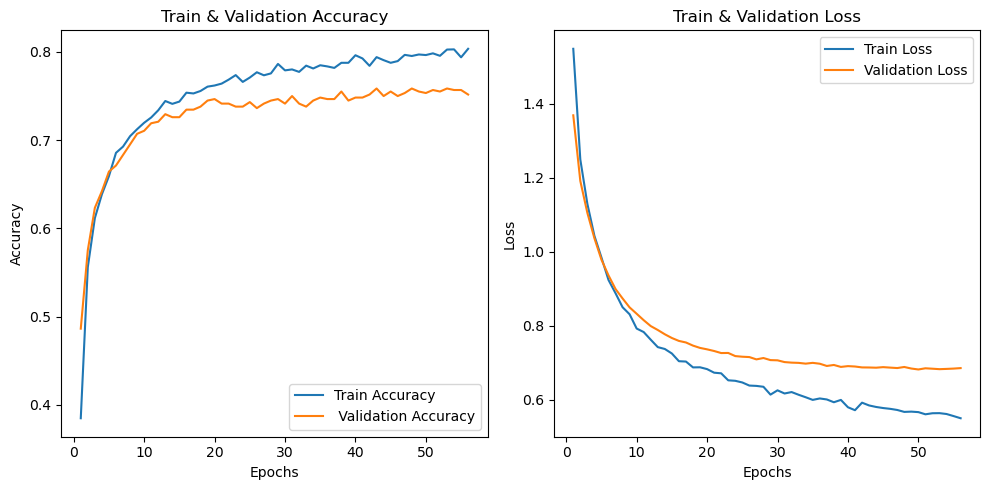

In [77]:
max_epochs = len(train_acc_history)-1
train_acc_history = train_acc_history[:max_epochs]
test_acc_history = test_acc_history[:max_epochs]

train_loss_history = train_loss_history[:max_epochs]
test_loss_history = test_loss_history[:max_epochs]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs+ 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, max_epochs + 1), test_acc_history, label=' Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, max_epochs + 1), test_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train & Validation Loss')

plt.tight_layout()
plt.show()
